# embeddings

Taken from this [tutorial](https://calmcode.io/course/embeddings)

Because the goal of this course is to build intuition, you're free not to follow along and just enjoy the video. If you want to reproduce this on your machine however ... feel free to follow along!

An experiment
Let's explore an experiment that involves training our own "letter" embeddings. You can follow along by downloading [this dataset hosted on calmcode](https://calmcode.io/datasets/headlines.html).

Once we have the dataset downloaded we'll prepare a dataset that takes all the pairs of letters in sequence such that we have a dataset to train on. The goal is to use the preceeding letter to predict the current one.

1. Connect this Colab
2. Create a "data" folder in Colab root directory
3. Please drag and drop "headlines.zip" to into this "data" directory

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import itertools as it

# Read data
words = pd.read_csv('/content/data/headlines.zip').loc[lambda d: ~d['text'].isna()]['text'][:20_000]

def sliding_window(txt):
    for i in range(len(txt) - 1):
        txt = txt.replace(" ", "_")
        yield txt[i], txt[i + 1]

# Make sliding window
window = list(it.chain(*[sliding_window(_) for _ in words]))
mapping = {c: i for i, c in enumerate(pd.DataFrame(window)[0].unique())}

# Training data
integers_in = np.array([mapping[w[0]] for w in window])
integers_out = np.array([mapping[w[1]] for w in window]).reshape(-1, 1)


With that done, we can proceed to setup a neural network for this training procedure. We're using keras with tensorflow here, but the same experiment can be done with Pytorch if you prefer.

The code below will create an embedding layer that we can pass letters into and get a vector out of.

In [2]:
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pylab as plt

num_letters = len(mapping) # typically 36 -> 26 letters + 10 numbers

# this one is so we might grab the embeddings
model_emb = Sequential()
embedding = Embedding(num_letters, 2, input_length=1)
model_emb.add(embedding)

idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v:k for k,v in mapping.items()}
# Generate the 2d embeddings on an untrained network
preds = model_emb.predict(idx_to_calc)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 


We can take the predictions on the untrained model and plot them using matplotlib.

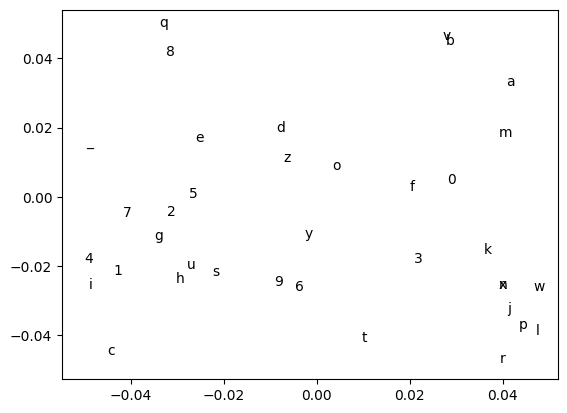

In [3]:
# Plot the 2d embeddings of each letter
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
      plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])


You'll notice that the letters are all over the place initially, but when we start training ... this might change.

This is the Keras model definition:

In [4]:
from tensorflow.keras.optimizers import Adam

# this one is so we might learn the mapping
model_pred = Sequential()
model_pred.add(embedding)
model_pred.add(Flatten())
model_pred.add(Dense(num_letters, activation="softmax"))

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_pred.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])


This is the code that generates the new plot after training for one epoch.

Epoch 1/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.1955 - loss: 2.6621
Epoch 2/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.1958 - loss: 2.6608
Epoch 3/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - accuracy: 0.1954 - loss: 2.6612
Epoch 4/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.1958 - loss: 2.6601
Epoch 5/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.1961 - loss: 2.6598
Epoch 6/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.1960 - loss: 2.6591
Epoch 7/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.1966 - loss: 2.6567
Epoch 8/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.1965 - loss: 2.6580
Epoch 9/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.1961 - loss: 2.6578
Epoch 10/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.1960 - loss: 2.6585
Epoch 11/25
23907/23907 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.1964 - loss: 2.65

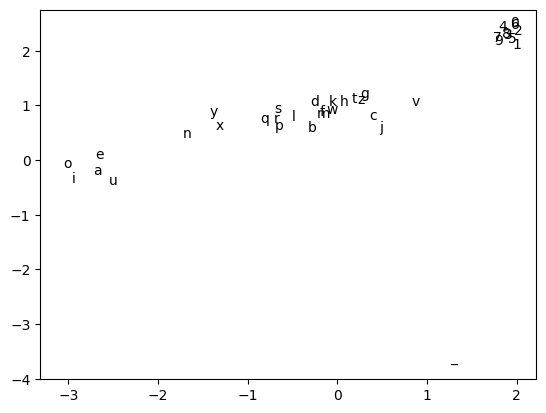

In [7]:
from sklearn.preprocessing import OneHotEncoder

#to_predict = OneHotEncoder(sparse=False).fit_transform(integers_out)
to_predict = OneHotEncoder(sparse_output=False).fit_transform(integers_out)
model_pred.fit(integers_in, to_predict, epochs=25, verbose=1)  # epochs=1

preds = model_emb.predict(idx_to_calc)
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])


So what might the chart change when we run this code?